# Data Visualization (PMT Level)

Visualization of charge and hits at the PMT level for a given event in the water cherenkov (WC) detector. For IWCD GEANT4 simulated dataset. <br>
Neutron captures are simulated as the signal (label 0), electron radiative background is simulated as a 0-20MeV background (label 1)

__copied (with some edits) from John Walker: https://github.com/WatChMaL/NeutronGNN/blob/master/visualisation/detector_geometry.ipynb__

import packages

In [2]:
import numpy as np
import argparse
import pos_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# example electron file
eminus_file = "/home/mattStubbs/watchmal/NeutronGNN/data/e-/4pi-dir/IWCDshort_ncapt_e-_E0to20MeV_unif-pos-R400-y300cm_4pi-dir_1000evts_1.npz"
# example neutron file
neutron_file = "/home/mattStubbs/watchmal/NeutronGNN/data/neutron/4pi-dir/IWCDshort_ncapt_neutron_E1to1MeV_unif-pos-R400-y300cm_4pi-dir_1000evts_1.npz"

# Map the PMTs modules to their row, index position
Every PMT is mapped to its relative row, index position based on the provided CSV file 'mPMT_to_row_col.csv'. <br>
Load this CSV file and turn it into a dictionary. uncomment to view print details.

In [23]:
csv_file = "mPMT_to_row_col.csv"
def GenMapping(csv_file):
    mPMT_to_index = {}
    with open(csv_file) as f:
        rows = f.readline().split(",")[1:]  
        # in first CSV row, the row index is given by the CSV column number
        rows = [int(r.strip()) for r in rows]

        for line in f:
            line_split = line.split(",")
            col = int(line_split[0].strip())
            # the column index is indicated by the first element of each CSV row
            # print("line_split: {}".format(line_split))
            for row, value in zip(rows, line_split[1:]):
#                 if value != "":
#                     print("row: {}, value: {}, col: {}".format(row, value, col))
#                 print(row, value)
                value = value.strip()
                if value: # If the value is not empty
                    mPMT_to_index[int(value)] = [row, col]
                    # for example, PMT 530 is mapped to row 17, col 28
    return mPMT_to_index

mPMT_to_index = GenMapping(csv_file)

# Map the PMTs to a relative module (mPMT) position
Every individual PMT belongs to a module of PMTs, called a 'mPMT'. There are 19 PMTs in a mPMT. <br>
PMTs rotated by Pi for endcap relative to barrel modules

In [24]:
def mpmt_mapping(_pmt_index):
    _pmt_in_module_id = _pmt_index%19
    _module_index = _pmt_index//19
    if _pmt_in_module_id >= 0 and _pmt_in_module_id<12:
        _theta = 2*np.pi*_pmt_in_module_id/12
        _radius = 0.4
    elif _pmt_in_module_id >= 12 and _pmt_in_module_id<18:
        _theta = 2*np.pi*(_pmt_in_module_id-12)/6
        _radius = 0.2
    else:
        _theta = 0
        _radius = 0
    if not pos_utils.is_barrel(_module_index):
        _theta = _theta+np.pi
    _mapping = [-_radius*np.sin(_theta), -_radius*np.cos(_theta)]
    return _mapping

# Plotting function
Plot a 2d projection of an event, showing the charge or time spread out over the PMT or mPMTs

In [25]:
def plot_event(path, event_number, data_type, display_type, save_path=None):
    """
    Plot a 2d projection of an event from the specified file
    
    Args:
        path         -- Path to the .npz file containing the event data
        event_number -- The event number to display
        data_type    -- Event data type to plot - "charge" or "timing"
        display_type -- The display type to use - "mPMT" or "PMT"
        save_path    -- Absolute path to save the figure as a .pdf file
    """
    
    # Assert the inputs are correct
    assert (event_number >= 0)
    assert (data_type == "charge" or data_type == "time")
    assert (display_type == "mPMT" or display_type == "PMT")
    
    # Load npz file
    npz_file = np.load(path, allow_pickle=True)
    
    # Get the relevant data arrays
    npz_pmts    = npz_file['digi_hit_pmt'][event_number]
    if data_type == "charge":
        npz_data = npz_file['digi_hit_charge'][event_number]
    elif data_type == "time":
        npz_data = npz_file['digi_hit_time'][event_number]
    #print(npz_data)
    
    # Assert that charges/times match number of hit PMTs
    assert( len(npz_pmts) == len(npz_data) )
    
    # Store positions of mPMTs/PMTs
    xs = []
    ys = []
    
    num_pmts = pos_utils.num_pmts()

    if display_type == "mPMT":
        data = np.zeros( num_pmts//19 )
        for mPMT_index in range(num_pmts//19):    
            index = mPMT_to_index[mPMT_index]
            xs.append(index[0])
            ys.append(index[1])
    elif display_type == "PMT":
        data = np.zeros( num_pmts )
        for PMT_index in range(num_pmts):
            mPMT_index = PMT_index//19
            mPMT_pos = mPMT_to_index[mPMT_index]
            PMT_map = mpmt_mapping(PMT_index)
            PMT_pos = [ mPMT_pos[0]+PMT_map[0], mPMT_pos[1]+PMT_map[1] ]
            xs.append(PMT_pos[0])
            ys.append(PMT_pos[1])

    # If display is mPMT then sum across module
    if display_type == "mPMT":
        denom = np.zeros( num_pmts//19 )
        for index, pmt in enumerate( npz_pmts ):
            mPMT_index = pos_utils.module_index( pmt )
            if data_type == "charge":
                data[mPMT_index] = data[mPMT_index] + npz_data[index]
            elif data_type == "time":
                # Subtract the WCSim trigger time offset
                data[mPMT_index] = data[mPMT_index] + (npz_data[index] - 950)
            denom[mPMT_index] = denom[mPMT_index] + 1
    elif display_type == "PMT":
        denom = np.zeros( num_pmts )
        for index, pmt in enumerate( npz_pmts ):
            if data_type == "charge":
                data[pmt] = npz_data[index]
            elif data_type == "time":
                # Subtract the WCSim trigger time offset
                data[pmt] = npz_data[index] - 950
            denom[pmt] = denom[pmt] + 1
    
    # If data_type time then average
    if data_type == "time":
            for index, module in enumerate( data ):
                if denom[index] > 0:
                    data[index] = data[index] / denom[index]

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    # Fix range for time plots to ignore dark noise
    vmin=None
    vmax=None
    if data_type == "time":
        vmin = 0
        vmax = 50
    if display_type == "mPMT":
        cs = ax.scatter(xs, ys, c=data, cmap=plt.cm.magma_r, vmin=vmin, vmax=vmax)
    elif display_type == "PMT":
        cs = ax.scatter(xs, ys, c=data, s=1, cmap=plt.cm.magma_r, vmin=vmin, vmax=vmax)
    
    plt.colorbar(cs)
    
    if save_path is not None:
        plt.savefig(save_path, format="pdf", dpi=30, bbox_inches="tight")

# Charge for an electron event with mPMTs as the geometry

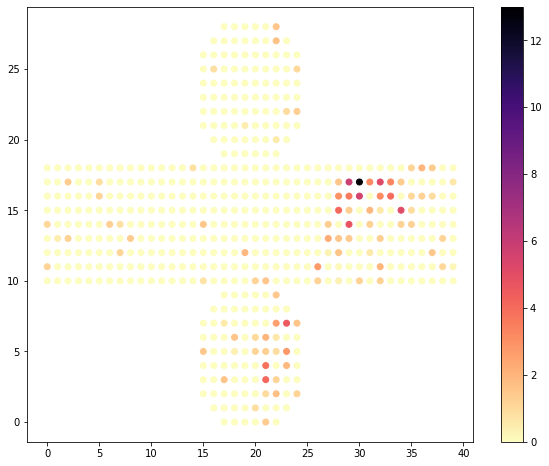

In [47]:
plot_event(eminus_file, 20, 'charge', 'mPMT')

# Charge for an electron event with PMTs as the geometry

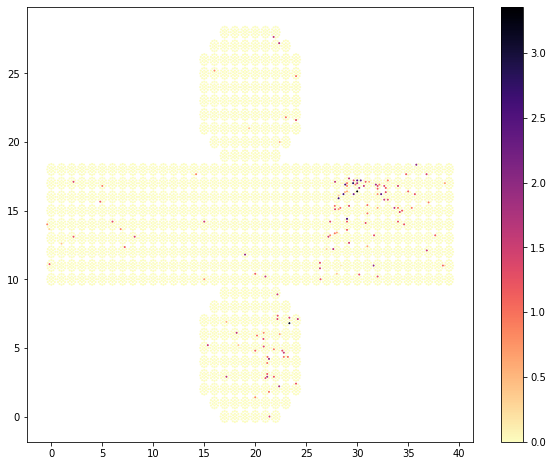

In [52]:
plot_event(eminus_file, 20, 'charge', 'PMT')

# Charge for a neutron event with mPMTs as the geometry

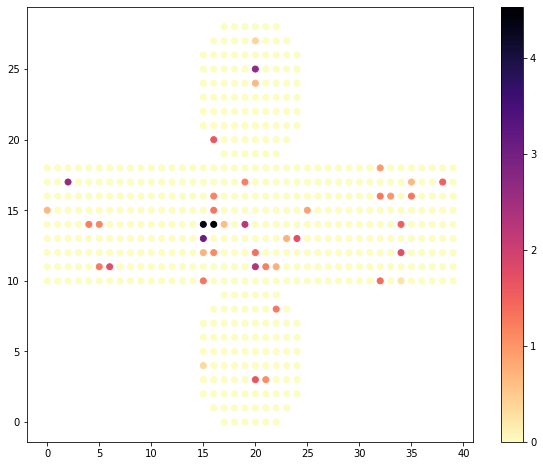

In [74]:
plot_event(neutron_file, 22, 'charge', 'mPMT')

### Charge for a neutron event with PMTs as the geometry

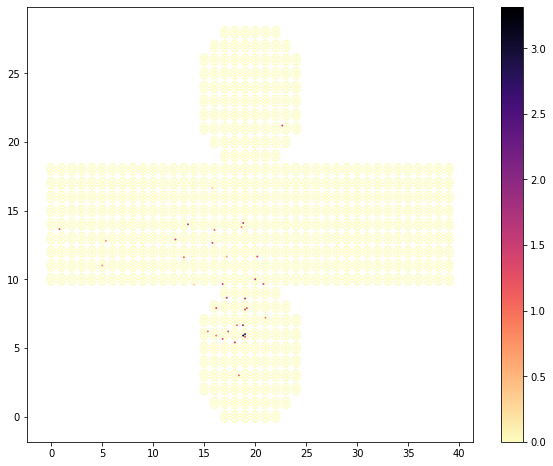

In [75]:
plot_event(neutron_file, 4, 'charge', 'PMT')

# Time for an electron event with mPMTs as the geometry

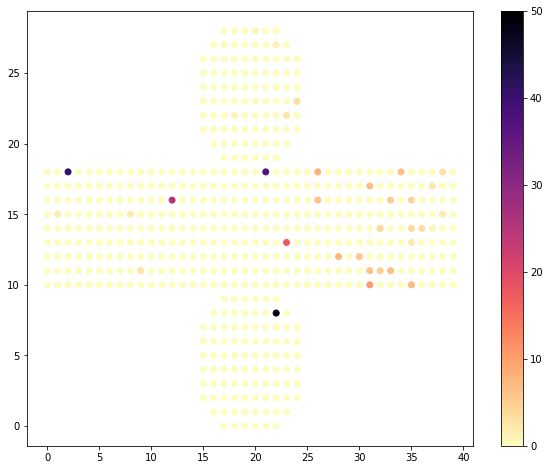

In [79]:
plot_event(eminus_file, 5, 'time', 'mPMT')

# Time for an electron event with PMTs as the geometry

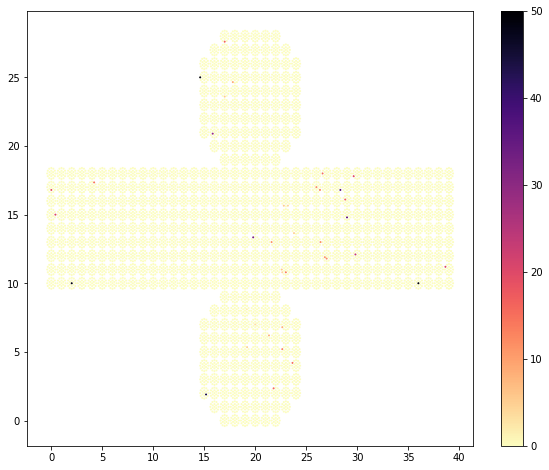

In [12]:
plot_event(eminus_file, 2, 'time', 'PMT')

# Time for a neutron event with mPMTs as the geometry

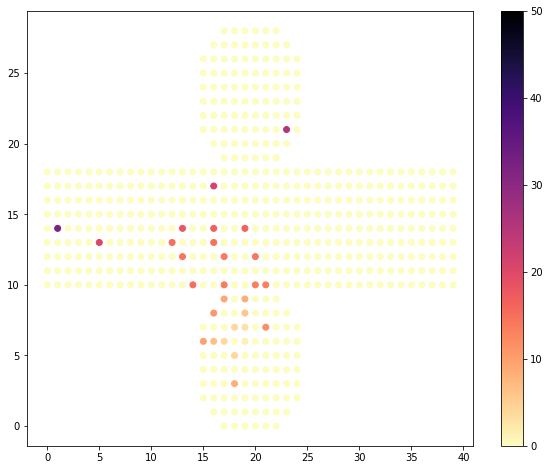

In [81]:
plot_event(neutron_file, 4, 'time', 'mPMT')

# Time for a neutron event with PMTs as the geometry

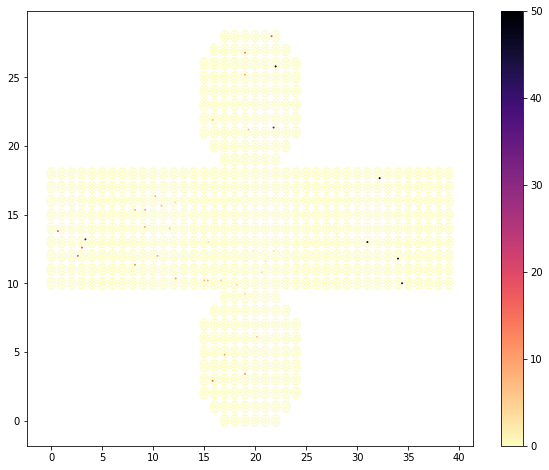

In [14]:
plot_event(neutron_file, 4, 'time', 'PMT')